<a href="https://colab.research.google.com/github/vikki284/GAN/blob/main/GAN_N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define the generator (UNet architecture)
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),  # Adjust input channels to 3
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),  # Adjust input channels to 3
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        return x

# Custom dataset class
class FaceDataset(Dataset):
    def __init__(self, root_dir_sketch, root_dir_real, transform=None):
        self.root_dir_sketch = root_dir_sketch
        self.root_dir_real = root_dir_real
        self.transform = transform
        self.sketch_files = os.listdir(root_dir_sketch)
        self.real_files = os.listdir(root_dir_real)

    def __len__(self):
        return min(len(self.sketch_files), len(self.real_files))

    def __getitem__(self, idx):
        sketch_img_name = os.path.join(self.root_dir_sketch, self.sketch_files[idx])
        real_img_name = os.path.join(self.root_dir_real, self.real_files[idx])
        sketch_image = Image.open(sketch_img_name).convert('RGB')  # Adjust to RGB
        real_image = Image.open(real_img_name)

        if self.transform:
            sketch_image = self.transform(sketch_image)
            real_image = self.transform(real_image)

        return sketch_image, real_image

# Function to display generated images during training
def show_generated_images(generator, noise, num_images=5, device='cpu'):
    with torch.no_grad():
        fake_images = generator(noise).cpu().detach()
        fake_images = fake_images.view(-1, 3, 256, 256)[:num_images]
        fake_images = (fake_images + 1) / 2  # Unnormalize

        fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
        for i in range(num_images):
            axes[i].imshow(fake_images[i].permute(1, 2, 0))
            axes[i].axis('off')
        plt.show()

# Hyperparameters
batch_size = 8
num_epochs = 15
lr = 0.02
device ="cpu"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
root_dir_sketch = r"D:\sketch1"
root_dir_real = r"D:\real1"
dataset = FaceDataset(root_dir_sketch, root_dir_real, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize generator and discriminator
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Specify the directory where you want to save the model files
save_dir = r"D:\MODELS"

# Training loop
for epoch in range(num_epochs):
    for i, (sketch_images, real_images) in enumerate(dataloader):
        sketch_images = sketch_images.to(device)
        real_images = real_images.to(device)

        # Train discriminator
        optimizer_D.zero_grad()
        fake_images = generator(sketch_images)
        real_preds = discriminator(real_images)
        fake_preds = discriminator(fake_images.detach())
        real_loss = criterion(real_preds, torch.ones_like(real_preds))
        fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        fake_preds = discriminator(fake_images)
        g_loss = criterion(fake_preds, torch.ones_like(fake_preds))
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Batch Step [{i}/{len(dataloader)}], "
                f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}"
            )

    # Save the model after each epoch
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'g_loss': g_loss,
        'd_loss': d_loss
    }, os.path.join(save_dir, f"model_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        try:
            # Save generated images and display
            show_generated_images(generator, sketch_images[:min(num_images, len(sketch_images))], device=device)
        except Exception as e:
            print(f"Error occurred during image generation and display: {e}")



C:\Users\Student\.conda\envs\miniproject_dev_vik\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\Student\.conda\envs\miniproject_dev_vik\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [0/15], Batch Step [0/26], Generator Loss: 0.0002, Discriminator Loss: 0.7122
Epoch [1/15], Batch Step [0/26], Generator Loss: 3.3080, Discriminator Loss: 6.0138
Epoch [2/15], Batch Step [0/26], Generator Loss: 2.1020, Discriminator Loss: 3.2614
Epoch [3/15], Batch Step [0/26], Generator Loss: 2.1777, Discriminator Loss: 2.9456
Epoch [4/15], Batch Step [0/26], Generator Loss: 2.3003, Discriminator Loss: 2.0201
Error occurred during image generation and display: name 'num_images' is not defined
Epoch [5/15], Batch Step [0/26], Generator Loss: 3.0393, Discriminator Loss: 0.0784
Epoch [6/15], Batch Step [0/26], Generator Loss: 2.0456, Discriminator Loss: 1.2675
Epoch [7/15], Batch Step [0/26], Generator Loss: 3.8099, Discriminator Loss: 0.1764
Epoch [8/15], Batch Step [0/26], Generator Loss: 3.1565, Discriminator Loss: 0.1374
Epoch [9/15], Batch Step [0/26], Generator Loss: 4.1077, Discriminator Loss: 0.0603
Error occurred during image generation and display: name 'num_images' is no

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


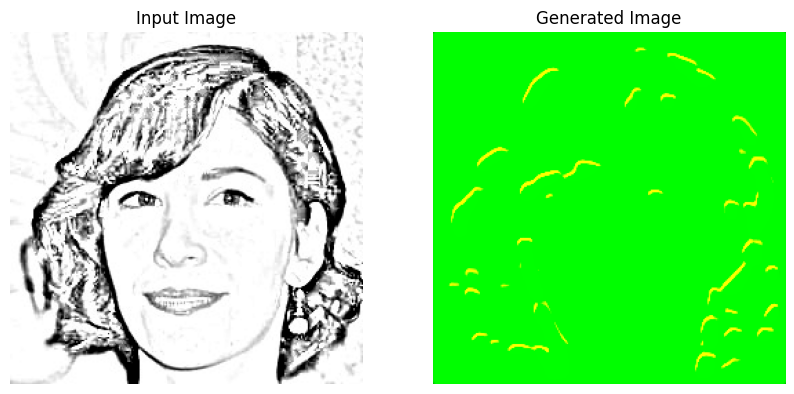

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


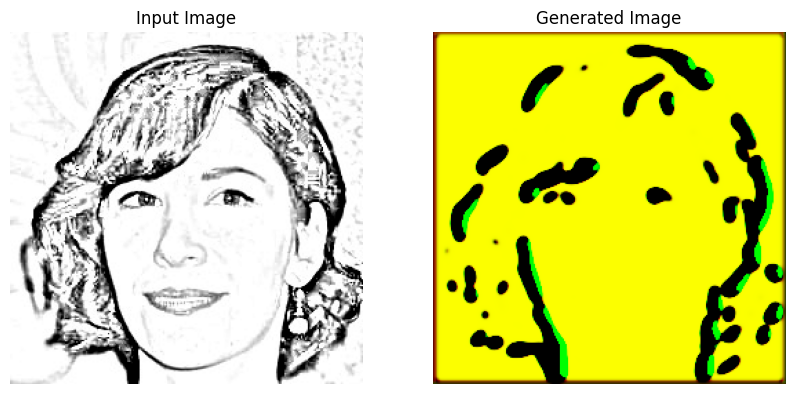

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


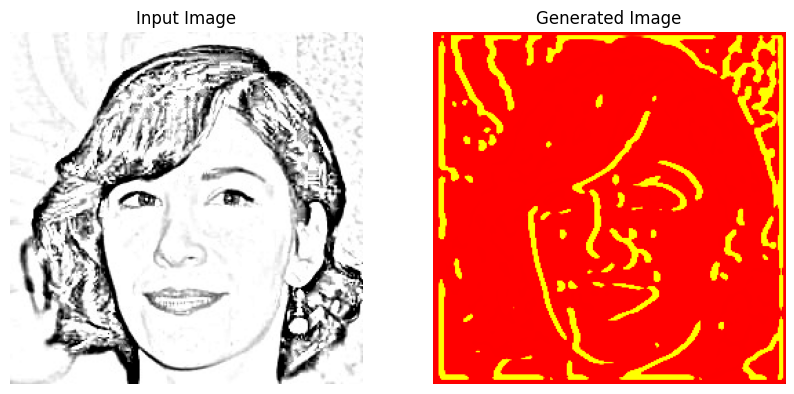

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


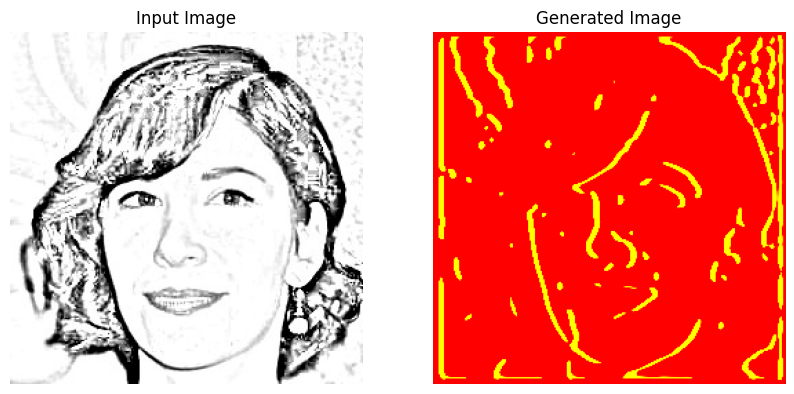

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


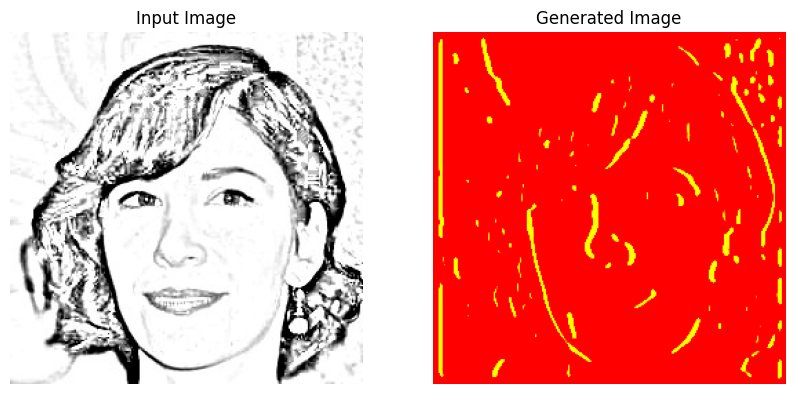

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


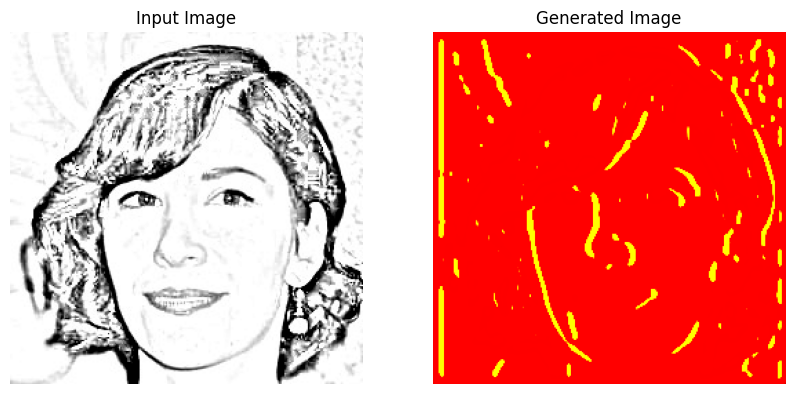

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


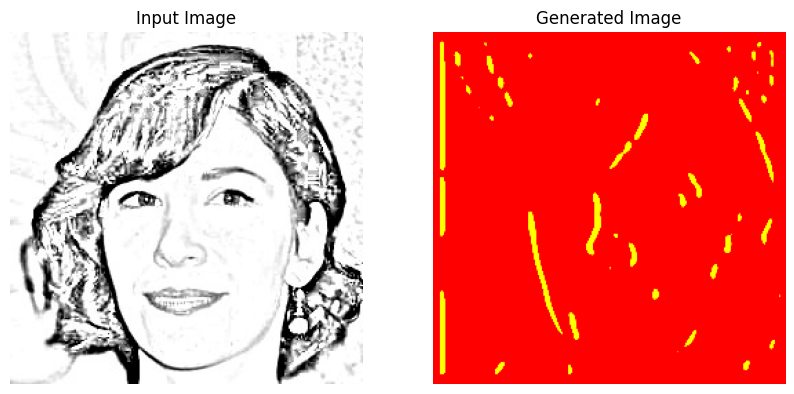

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


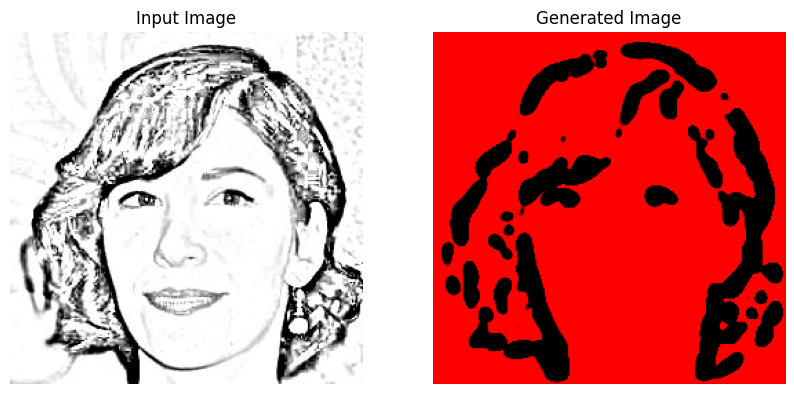

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


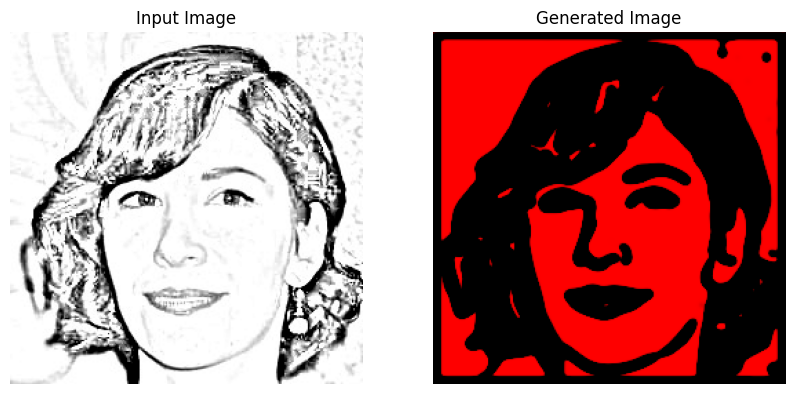

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


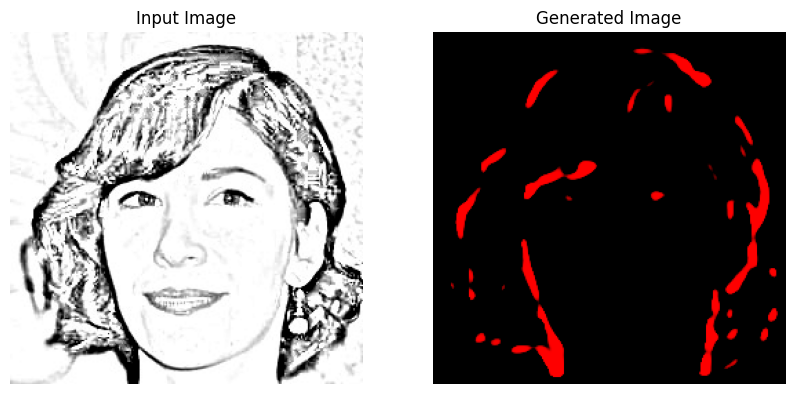

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


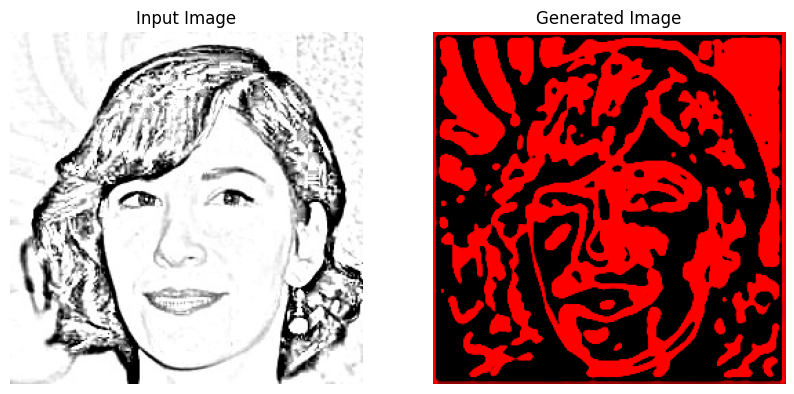

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


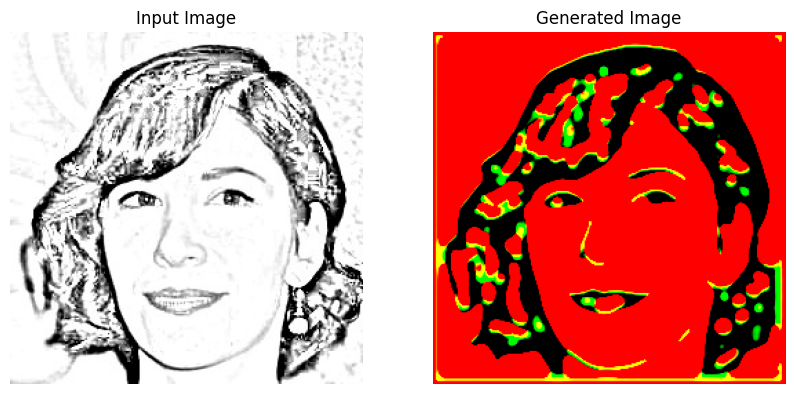

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


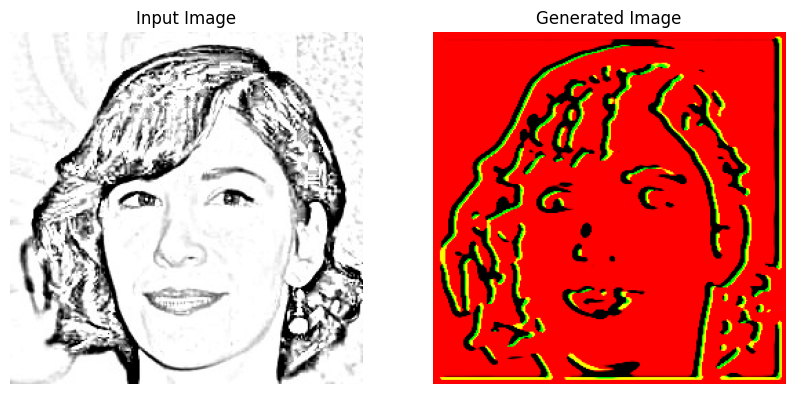

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


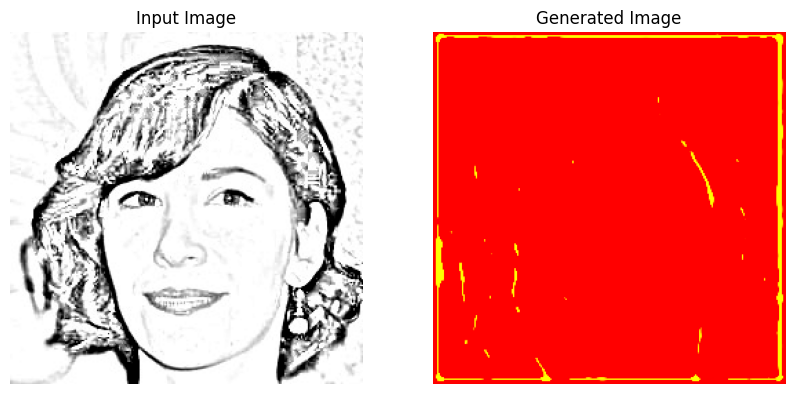

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


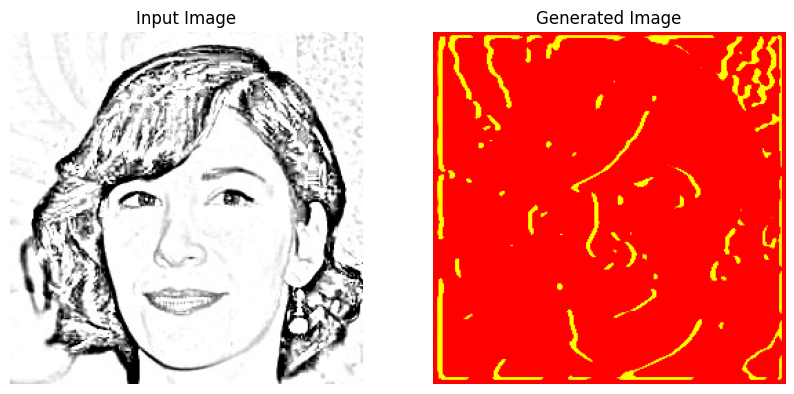

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define the generator (UNet architecture)
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),  # Adjust input channels to 3
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Function to load the generator model from a checkpoint file
def load_generator(generator_path):
    generator = UNetGenerator()  # Assuming UNetGenerator is defined elsewhere
    checkpoint = torch.load(generator_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()
    return generator

# Function to load an image
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# Function to save an image
def save_image(image_tensor, output_path):
    # Denormalize the image tensor
    image = image_tensor.detach().cpu().squeeze().permute(1, 2, 0)
    image = ((image + 1) / 2) * 255  # Assuming the image was normalized to [-1, 1]
    image = image.numpy().astype('uint8')
    # Save the image using PIL
    Image.fromarray(image).save(output_path)

# Function to display input and generated images
def show_images(input_image, generated_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image.squeeze().permute(1, 2, 0))
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(generated_image.squeeze().permute(1, 2, 0))
    axes[1].set_title('Generated Image')
    axes[1].axis('off')
    plt.show()

# Directory containing the saved models
model_dir = r"D:\MODELS"

# Directory containing the input images
input_image_dir = r"D:\sketch1"

# Directory where generated images for each epoch will be saved
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Load each saved model and make predictions
for generator_name in os.listdir(model_dir):
    generator_path = os.path.join(model_dir, generator_name)
    generator = load_generator(generator_path)

    # Create a subdirectory for the current epoch
    epoch_output_dir = os.path.join(output_dir, f"epoch_{generator_name.split('_')[-1]}")
    os.makedirs(epoch_output_dir, exist_ok=True)

    # Load and process input images
    for image_name in os.listdir(input_image_dir):
        input_image_path = os.path.join(input_image_dir, image_name)
        input_image = load_image(input_image_path)

        # Generate images
        with torch.no_grad():
            generated_image = generator(input_image)

        # Save the generated image
        output_image_path = os.path.join(epoch_output_dir, f"generated_{image_name}")
        save_image(generated_image.squeeze(), output_image_path)

        # Display only one generated image for each input image
        show_images(input_image, generated_image)
        break  # Exit the inner loop after displaying one generated image per input image


